Lambda School Data Science

*Unit 2, Sprint 1, Module 3*

---

# Ridge Regression

## Assignment

We're going back to our other **New York City** real estate dataset. Instead of predicting apartment rents, you'll predict property sales prices.

But not just for condos in Tribeca...

- [ ] Use a subset of the data where `BUILDING_CLASS_CATEGORY` == `'01 ONE FAMILY DWELLINGS'` and the sale price was more than 100 thousand and less than 2 million.
- [ ] Do train/test split. Use data from January — March 2019 to train. Use data from April 2019 to test.
- [ ] Do one-hot encoding of categorical features.
- [ ] Do feature selection with `SelectKBest`.
- [ ] Fit a ridge regression model with multiple features. Use the `normalize=True` parameter (or do [feature scaling](https://scikit-learn.org/stable/modules/preprocessing.html) beforehand — use the scaler's `fit_transform` method with the train set, and the scaler's `transform` method with the test set)
- [ ] Get mean absolute error for the test set.
- [ ] As always, commit your notebook to your fork of the GitHub repo.

The [NYC Department of Finance](https://www1.nyc.gov/site/finance/taxes/property-rolling-sales-data.page) has a glossary of property sales terms and NYC Building Class Code Descriptions. The data comes from the [NYC OpenData](https://data.cityofnewyork.us/browse?q=NYC%20calendar%20sales) portal.


## Stretch Goals

Don't worry, you aren't expected to do all these stretch goals! These are just ideas to consider and choose from.

- [ ] Add your own stretch goal(s) !
- [ ] Instead of `Ridge`, try `LinearRegression`. Depending on how many features you select, your errors will probably blow up! 💥
- [ ] Instead of `Ridge`, try [`RidgeCV`](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.RidgeCV.html).
- [ ] Learn more about feature selection:
    - ["Permutation importance"](https://www.kaggle.com/dansbecker/permutation-importance)
    - [scikit-learn's User Guide for Feature Selection](https://scikit-learn.org/stable/modules/feature_selection.html)
    - [mlxtend](http://rasbt.github.io/mlxtend/) library
    - scikit-learn-contrib libraries: [boruta_py](https://github.com/scikit-learn-contrib/boruta_py) & [stability-selection](https://github.com/scikit-learn-contrib/stability-selection)
    - [_Feature Engineering and Selection_](http://www.feat.engineering/) by Kuhn & Johnson.
- [ ] Try [statsmodels](https://www.statsmodels.org/stable/index.html) if you’re interested in more inferential statistical approach to linear regression and feature selection, looking at p values and 95% confidence intervals for the coefficients.
- [ ] Read [_An Introduction to Statistical Learning_](http://faculty.marshall.usc.edu/gareth-james/ISL/ISLR%20Seventh%20Printing.pdf), Chapters 1-3, for more math & theory, but in an accessible, readable way.
- [ ] Try [scikit-learn pipelines](https://scikit-learn.org/stable/modules/compose.html).

In [0]:
%%capture
import sys

# If you're on Colab:
if 'google.colab' in sys.modules:
    DATA_PATH = 'https://raw.githubusercontent.com/LambdaSchool/DS-Unit-2-Applied-Modeling/master/data/'
    !pip install category_encoders==2.*

# If you're working locally:
else:
    DATA_PATH = '../data/'
    
# Ignore this Numpy warning when using Plotly Express:
# FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
import warnings
warnings.filterwarnings(action='ignore', category=FutureWarning, module='numpy')

In [0]:
import pandas as pd
import pandas_profiling

# Read New York City property sales data
df = pd.read_csv(DATA_PATH+'condos/NYC_Citywide_Rolling_Calendar_Sales.csv')

# Change column names: replace spaces with underscores
df.columns = [col.replace(' ', '_') for col in df]

# SALE_PRICE was read as strings.
# Remove symbols, convert to integer
df['SALE_PRICE'] = (
    df['SALE_PRICE']
    .str.replace('$','')
    .str.replace('-','')
    .str.replace(',','')
    .astype(int)
)

In [0]:
# BOROUGH is a numeric column, but arguably should be a categorical feature,
# so convert it from a number to a string
df['BOROUGH'] = df['BOROUGH'].astype(str)

In [0]:
# Reduce cardinality for NEIGHBORHOOD feature

# Get a list of the top 10 neighborhoods
top10 = df['NEIGHBORHOOD'].value_counts()[:10].index

# At locations where the neighborhood is NOT in the top 10, 
# replace the neighborhood with 'OTHER'
df.loc[~df['NEIGHBORHOOD'].isin(top10), 'NEIGHBORHOOD'] = 'OTHER'

# My Work

## Extra

In [0]:
# Make df['SALE_DATE'] to a more usable datetime method
df['SALE_DATE'] = pd.to_datetime(df['SALE_DATE'])

In [6]:
df.head()

,BOROUGH,NEIGHBORHOOD,BUILDING_CLASS_CATEGORY,TAX_CLASS_AT_PRESENT,BLOCK,LOT,EASE-MENT,BUILDING_CLASS_AT_PRESENT,ADDRESS,APARTMENT_NUMBER,ZIP_CODE,RESIDENTIAL_UNITS,COMMERCIAL_UNITS,TOTAL_UNITS,LAND_SQUARE_FEET,GROSS_SQUARE_FEET,YEAR_BUILT,TAX_CLASS_AT_TIME_OF_SALE,BUILDING_CLASS_AT_TIME_OF_SALE,SALE_PRICE,SALE_DATE
0,1,OTHER,13 CONDOS - ELEVATOR APARTMENTS,2,716,1246,NaN,R4,"447 WEST 18TH STREET, PH12A",PH12A,10011.0,1.0,0.0,1.0,"10,733",1979.0,2007.0,2,R4,0,2019-01-01
1,1,OTHER,21 OFFICE BUILDINGS,4,812,68,NaN,O5,144 WEST 37TH STREET,NaN,10018.0,0.0,6.0,6.0,"2,962",15435.0,1920.0,4,O5,0,2019-01-01
2,1,OTHER,21 OFFICE BUILDINGS,4,839,69,NaN,O5,40 WEST 38TH STREET,NaN,10018.0,0.0,7.0,7.0,"2,074",11332.0,1930.0,4,O5,0,2019-01-01
3,1,OTHER,13 CONDOS - ELEVATOR APARTMENTS,2,592,1041,NaN,R4,"1 SHERIDAN SQUARE, 8C",8C,10014.0,1.0,0.0,1.0,0,500.0,0.0,2,R4,0,2019-01-01
4,1,UPPER EAST SIDE (59-79),15 CONDOS - 2-10 UNIT RESIDENTIAL,2C,1379,1402,NaN,R1,"20 EAST 65TH STREET, B",B,10065.0,1.0,0.0,1.0,0,6406.0,0.0,2,R1,0,2019-01-01


In [7]:
df.describe(include='all')

,BOROUGH,NEIGHBORHOOD,BUILDING_CLASS_CATEGORY,TAX_CLASS_AT_PRESENT,BLOCK,LOT,EASE-MENT,BUILDING_CLASS_AT_PRESENT,ADDRESS,APARTMENT_NUMBER,ZIP_CODE,RESIDENTIAL_UNITS,COMMERCIAL_UNITS,TOTAL_UNITS,LAND_SQUARE_FEET,GROSS_SQUARE_FEET,YEAR_BUILT,TAX_CLASS_AT_TIME_OF_SALE,BUILDING_CLASS_AT_TIME_OF_SALE,SALE_PRICE,SALE_DATE
count,23040,23040,23040,23039,23040.000000,23040.000000,0.0,23039,23040,5201,23039.000000,23039.000000,23039.000000,23039.000000,22987,2.303900e+04,23005.000000,23040.000000,23040,2.304000e+04,23040
unique,5,11,44,10,NaN,NaN,NaN,146,22691,1724,NaN,NaN,NaN,NaN,3652,NaN,NaN,NaN,147,NaN,120
top,4,OTHER,01 ONE FAMILY DWELLINGS,1,NaN,NaN,NaN,D4,100 JEROME STREET,4,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN,D4,NaN,2019-01-24 00:00:00
freq,7494,19117,5061,11071,NaN,NaN,NaN,3408,6,99,NaN,NaN,NaN,NaN,7500,NaN,NaN,NaN,3408,NaN,480
first,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-01-01 00:00:00
last,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-04-30 00:00:00
mean,NaN,NaN,NaN,NaN,4459.116493,353.948481,NaN,NaN,NaN,NaN,10791.186987,1.827423,0.286514,2.320891,NaN,3.508555e+03,1819.671724,1.624479,NaN,1.328133e+06,NaN
std,NaN,NaN,NaN,NaN,3713.269887,628.025255,NaN,NaN,NaN,NaN,1103.414210,10.090432,5.778224,12.070554,NaN,2.218610e+04,488.376571,0.803898,NaN,1.025394e+07,NaN
min,NaN,NaN,NaN,NaN,1.000000,1.000000,NaN,NaN,NaN,NaN,0.000000,0.000000,-148.000000,0.000000,NaN,0.000000e+00,0.000000,1.000000,NaN,0.000000e+00,NaN
25%,NaN,NaN,NaN,NaN,1341.000000,22.000000,NaN,NaN,NaN,NaN,10306.000000,0.000000,0.000000,1.000000,NaN,4.940000e+02,1920.000000,1.000000,NaN,0.000000e+00,NaN


In [8]:
df.shape

(23040, 21)

In [0]:
# I don't think this columns add anything
df.drop(['EASE-MENT', 'APARTMENT_NUMBER'], axis=1, inplace=True)

In [0]:
# Not sure why Land_SQUARE_FEET wouldn't be a int instead of a string
df['LAND_SQUARE_FEET'] = df['LAND_SQUARE_FEET'].replace({',':''},regex=True)
df['LAND_SQUARE_FEET'] = pd.to_numeric(df['LAND_SQUARE_FEET'], errors='coerce',)

In [11]:
df.isnull().sum()

BOROUGH                            0
NEIGHBORHOOD                       0
BUILDING_CLASS_CATEGORY            0
TAX_CLASS_AT_PRESENT               1
BLOCK                              0
LOT                                0
BUILDING_CLASS_AT_PRESENT          1
ADDRESS                            0
ZIP_CODE                           1
RESIDENTIAL_UNITS                  1
COMMERCIAL_UNITS                   1
TOTAL_UNITS                        1
LAND_SQUARE_FEET                  54
GROSS_SQUARE_FEET                  1
YEAR_BUILT                        35
TAX_CLASS_AT_TIME_OF_SALE          0
BUILDING_CLASS_AT_TIME_OF_SALE     0
SALE_PRICE                         0
SALE_DATE                          0
dtype: int64

## Use a subset of the data where BUILDING_CLASS_CATEGORY == '01 ONE FAMILY DWELLINGS' and the sale price was more than 100 thousand and less than 2 million.

In [0]:
df = df[df['BUILDING_CLASS_CATEGORY'] == '01 ONE FAMILY DWELLINGS']

In [13]:
df.shape

(5061, 19)

##Do train/test split. Use data from January — March 2019 to train. Use data from April 2019 to test.

In [14]:
start_date = '2019-01-01'
end_date = '2019-03-31'
traindate = (df['SALE_DATE'] >= start_date) & (df['SALE_DATE'] <= end_date)
train = df.loc[traindate]
print(train.shape)
train.head()

(4094, 19)


,BOROUGH,NEIGHBORHOOD,BUILDING_CLASS_CATEGORY,TAX_CLASS_AT_PRESENT,BLOCK,LOT,BUILDING_CLASS_AT_PRESENT,ADDRESS,ZIP_CODE,RESIDENTIAL_UNITS,COMMERCIAL_UNITS,TOTAL_UNITS,LAND_SQUARE_FEET,GROSS_SQUARE_FEET,YEAR_BUILT,TAX_CLASS_AT_TIME_OF_SALE,BUILDING_CLASS_AT_TIME_OF_SALE,SALE_PRICE,SALE_DATE
7,2,OTHER,01 ONE FAMILY DWELLINGS,1,4090,37,A1,1193 SACKET AVENUE,10461.0,1.0,0.0,1.0,3404.0,1328.0,1925.0,1,A1,0,2019-01-01
8,2,OTHER,01 ONE FAMILY DWELLINGS,1,4120,18,A5,1215 VAN NEST AVENUE,10461.0,1.0,0.0,1.0,2042.0,1728.0,1935.0,1,A5,0,2019-01-01
9,2,OTHER,01 ONE FAMILY DWELLINGS,1,4120,20,A5,1211 VAN NEST AVENUE,10461.0,1.0,0.0,1.0,2042.0,1728.0,1935.0,1,A5,0,2019-01-01
42,3,OTHER,01 ONE FAMILY DWELLINGS,1,6809,54,A1,2601 AVENUE R,11229.0,1.0,0.0,1.0,3333.0,1262.0,1925.0,1,A1,0,2019-01-01
44,3,OTHER,01 ONE FAMILY DWELLINGS,1,5495,801,A9,4832 BAY PARKWAY,11230.0,1.0,0.0,1.0,6800.0,1325.0,1930.0,1,A9,550000,2019-01-01


In [15]:
start_date = '2019-04-01'
end_date = '2019-04-30'
testdate = (df['SALE_DATE'] >= start_date) & (df['SALE_DATE'] <= end_date)
test = df.loc[testdate]
print(test.shape)
test.sample(5)

(967, 19)


,BOROUGH,NEIGHBORHOOD,BUILDING_CLASS_CATEGORY,TAX_CLASS_AT_PRESENT,BLOCK,LOT,BUILDING_CLASS_AT_PRESENT,ADDRESS,ZIP_CODE,RESIDENTIAL_UNITS,COMMERCIAL_UNITS,TOTAL_UNITS,LAND_SQUARE_FEET,GROSS_SQUARE_FEET,YEAR_BUILT,TAX_CLASS_AT_TIME_OF_SALE,BUILDING_CLASS_AT_TIME_OF_SALE,SALE_PRICE,SALE_DATE
20372,4,OTHER,01 ONE FAMILY DWELLINGS,1,7366,20,A1,48-30 208TH STREET,11364.0,1.0,0.0,1.0,4200.0,1720.0,1925.0,1,A1,0,2019-04-11
20704,4,OTHER,01 ONE FAMILY DWELLINGS,1,10274,10,A1,17517 111 AVENUE,11433.0,1.0,0.0,1.0,4000.0,1575.0,1925.0,1,A1,0,2019-04-12
20982,4,OTHER,01 ONE FAMILY DWELLINGS,1,12103,23,A1,126-15 148 STREET,11436.0,1.0,0.0,1.0,2000.0,992.0,1925.0,1,A1,0,2019-04-15
21765,4,OTHER,01 ONE FAMILY DWELLINGS,1,11660,18,A1,114-16 135 STREET,11420.0,1.0,0.0,1.0,2300.0,896.0,1930.0,1,A1,225000,2019-04-18
22813,3,OTHER,01 ONE FAMILY DWELLINGS,1,7647,4,A1,2915 AVENUE M,11210.0,1.0,0.0,1.0,2489.0,1312.0,1925.0,1,A1,0,2019-04-29


In [16]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
BLOCK,5061.0,6808.683264,3907.147819,17.0,3973.0,6315.0,9708.0,16350.0
LOT,5061.0,72.994467,156.833411,1.0,21.0,41.0,68.0,2780.0
ZIP_CODE,5061.0,11040.995653,501.017045,0.0,10465.0,11236.0,11413.0,11697.0
RESIDENTIAL_UNITS,5061.0,0.990911,0.096972,0.0,1.0,1.0,1.0,2.0
COMMERCIAL_UNITS,5061.0,0.022723,0.152960,0.0,0.0,0.0,0.0,2.0
TOTAL_UNITS,5061.0,1.013634,0.182245,0.0,1.0,1.0,1.0,3.0
LAND_SQUARE_FEET,5061.0,3204.771191,1966.444364,0.0,2000.0,2600.0,4000.0,37500.0
GROSS_SQUARE_FEET,5061.0,1559.323849,740.282754,0.0,1168.0,1400.0,1775.0,12618.0
YEAR_BUILT,5061.0,1942.234539,37.761218,0.0,1925.0,1935.0,1955.0,2018.0
TAX_CLASS_AT_TIME_OF_SALE,5061.0,1.000000,0.000000,1.0,1.0,1.0,1.0,1.0


In [17]:
df.select_dtypes(exclude='number').columns

Index(['BOROUGH', 'NEIGHBORHOOD', 'BUILDING_CLASS_CATEGORY',
       'TAX_CLASS_AT_PRESENT', 'BUILDING_CLASS_AT_PRESENT', 'ADDRESS',
       'BUILDING_CLASS_AT_TIME_OF_SALE', 'SALE_DATE'],
      dtype='object')

## Do one-hot encoding of categorical features.

In [0]:
target = 'SALE_PRICE'
high_cardinality = ['SALE_DATE', 'ADDRESS', 'SALE_DATE']
features = train.columns.drop([target] + high_cardinality)

In [0]:
X_train = train[features]
y_train = train[target]
X_test = test[features]
y_test = test[target]

In [20]:
X_train

,BOROUGH,NEIGHBORHOOD,BUILDING_CLASS_CATEGORY,TAX_CLASS_AT_PRESENT,BLOCK,LOT,BUILDING_CLASS_AT_PRESENT,ZIP_CODE,RESIDENTIAL_UNITS,COMMERCIAL_UNITS,TOTAL_UNITS,LAND_SQUARE_FEET,GROSS_SQUARE_FEET,YEAR_BUILT,TAX_CLASS_AT_TIME_OF_SALE,BUILDING_CLASS_AT_TIME_OF_SALE
7,2,OTHER,01 ONE FAMILY DWELLINGS,1,4090,37,A1,10461.0,1.0,0.0,1.0,3404.0,1328.0,1925.0,1,A1
8,2,OTHER,01 ONE FAMILY DWELLINGS,1,4120,18,A5,10461.0,1.0,0.0,1.0,2042.0,1728.0,1935.0,1,A5
9,2,OTHER,01 ONE FAMILY DWELLINGS,1,4120,20,A5,10461.0,1.0,0.0,1.0,2042.0,1728.0,1935.0,1,A5
42,3,OTHER,01 ONE FAMILY DWELLINGS,1,6809,54,A1,11229.0,1.0,0.0,1.0,3333.0,1262.0,1925.0,1,A1
44,3,OTHER,01 ONE FAMILY DWELLINGS,1,5495,801,A9,11230.0,1.0,0.0,1.0,6800.0,1325.0,1930.0,1,A9
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18139,5,OTHER,01 ONE FAMILY DWELLINGS,1,1508,207,A9,10314.0,1.0,0.0,1.0,2375.0,1292.0,1970.0,1,A9
18140,5,OTHER,01 ONE FAMILY DWELLINGS,1,822,41,A2,10314.0,1.0,0.0,1.0,6000.0,1020.0,1960.0,1,A2
18147,4,OTHER,01 ONE FAMILY DWELLINGS,1,11159,11,A0,11429.0,1.0,0.0,1.0,3910.0,1163.0,1950.0,1,A0
18152,5,OTHER,01 ONE FAMILY DWELLINGS,1,2005,107,A5,10314.0,1.0,0.0,1.0,1872.0,1944.0,1988.0,1,A5


In [21]:
print(X_train.shape, X_test.shape)

(4094, 16) (967, 16)


In [0]:
import category_encoders as cs

In [0]:
encoder = cs.OneHotEncoder(use_cat_names=True)
X_train = encoder.fit_transform(X_train)
X_test = encoder.transform(X_test)

In [24]:
X_train

,BOROUGH_2,BOROUGH_3,BOROUGH_4,BOROUGH_5,BOROUGH_1,NEIGHBORHOOD_OTHER,NEIGHBORHOOD_FLUSHING-NORTH,NEIGHBORHOOD_BOROUGH PARK,NEIGHBORHOOD_UPPER EAST SIDE (59-79),NEIGHBORHOOD_BEDFORD STUYVESANT,NEIGHBORHOOD_FOREST HILLS,NEIGHBORHOOD_ASTORIA,NEIGHBORHOOD_UPPER EAST SIDE (79-96),NEIGHBORHOOD_UPPER WEST SIDE (79-96),BUILDING_CLASS_CATEGORY_01 ONE FAMILY DWELLINGS,TAX_CLASS_AT_PRESENT_1,TAX_CLASS_AT_PRESENT_1D,TAX_CLASS_AT_PRESENT_1B,BLOCK,LOT,BUILDING_CLASS_AT_PRESENT_A1,BUILDING_CLASS_AT_PRESENT_A5,BUILDING_CLASS_AT_PRESENT_A9,BUILDING_CLASS_AT_PRESENT_A3,BUILDING_CLASS_AT_PRESENT_A2,BUILDING_CLASS_AT_PRESENT_A0,BUILDING_CLASS_AT_PRESENT_S1,BUILDING_CLASS_AT_PRESENT_A7,BUILDING_CLASS_AT_PRESENT_A4,BUILDING_CLASS_AT_PRESENT_A6,BUILDING_CLASS_AT_PRESENT_A8,BUILDING_CLASS_AT_PRESENT_B2,BUILDING_CLASS_AT_PRESENT_S0,BUILDING_CLASS_AT_PRESENT_B3,BUILDING_CLASS_AT_PRESENT_V0,ZIP_CODE,RESIDENTIAL_UNITS,COMMERCIAL_UNITS,TOTAL_UNITS,LAND_SQUARE_FEET,GROSS_SQUARE_FEET,YEAR_BUILT,TAX_CLASS_AT_TIME_OF_SALE,BUILDING_CLASS_AT_TIME_OF_SALE_A1,BUILDING_CLASS_AT_TIME_OF_SALE_A5,BUILDING_CLASS_AT_TIME_OF_SALE_A9,BUILDING_CLASS_AT_TIME_OF_SALE_A3,BUILDING_CLASS_AT_TIME_OF_SALE_A2,BUILDING_CLASS_AT_TIME_OF_SALE_A0,BUILDING_CLASS_AT_TIME_OF_SALE_S1,BUILDING_CLASS_AT_TIME_OF_SALE_A7,BUILDING_CLASS_AT_TIME_OF_SALE_A4,BUILDING_CLASS_AT_TIME_OF_SALE_A6,BUILDING_CLASS_AT_TIME_OF_SALE_A8,BUILDING_CLASS_AT_TIME_OF_SALE_S0
7,1,0,0,0,0,1,0,0,0,0,0,0,0,0,1,1,0,0,4090,37,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,10461.0,1.0,0.0,1.0,3404.0,1328.0,1925.0,1,1,0,0,0,0,0,0,0,0,0,0,0
8,1,0,0,0,0,1,0,0,0,0,0,0,0,0,1,1,0,0,4120,18,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,10461.0,1.0,0.0,1.0,2042.0,1728.0,1935.0,1,0,1,0,0,0,0,0,0,0,0,0,0
9,1,0,0,0,0,1,0,0,0,0,0,0,0,0,1,1,0,0,4120,20,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,10461.0,1.0,0.0,1.0,2042.0,1728.0,1935.0,1,0,1,0,0,0,0,0,0,0,0,0,0
42,0,1,0,0,0,1,0,0,0,0,0,0,0,0,1,1,0,0,6809,54,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,11229.0,1.0,0.0,1.0,3333.0,1262.0,1925.0,1,1,0,0,0,0,0,0,0,0,0,0,0
44,0,1,0,0,0,1,0,0,0,0,0,0,0,0,1,1,0,0,5495,801,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,11230.0,1.0,0.0,1.0,6800.0,1325.0,1930.0,1,0,0,1,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18139,0,0,0,1,0,1,0,0,0,0,0,0,0,0,1,1,0,0,1508,207,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,10314.0,1.0,0.0,1.0,2375.0,1292.0,1970.0,1,0,0,1,0,0,0,0,0,0,0,0,0
18140,0,0,0,1,0,1,0,0,0,0,0,0,0,0,1,1,0,0,822,41,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,10314.0,1.0,0.0,1.0,6000.0,1020.0,1960.0,1,0,0,0,0,1,0,0,0,0,0,0,0
18147,0,0,1,0,0,1,0,0,0,0,0,0,0,0,1,1,0,0,11159,11,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,11429.0,1.0,0.0,1.0,3910.0,1163.0,1950.0,1,0,0,0,0,0,1,0,0,0,0,0,0
18152,0,0,0,1,0,1,0,0,0,0,0,0,0,0,1,1,0,0,2005,107,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,10314.0,1.0,0.0,1.0,1872.0,1944.0,1988.0,1,0,1,0,0,0,0,0,0,0,0,0,0


In [25]:
print(X_train.shape, X_test.shape)

(4094, 55) (967, 55)


## Do feature selection with SelectKBest.

In [34]:
from sklearn.feature_selection import f_regression, SelectKBest

selector = SelectKBest(score_func=f_regression, k=15)

X_train_selected = selector.fit_transform(X_train, y_train)
X_test_selected = selector.transform(X_test)
X_train_selected.shape, X_test_selected.shape

/usr/local/lib/python3.6/dist-packages/sklearn/feature_selection/_univariate_selection.py:299: RuntimeWarning: divide by zero encountered in true_divide
  corr /= X_norms
/usr/local/lib/python3.6/dist-packages/sklearn/feature_selection/_univariate_selection.py:304: RuntimeWarning: invalid value encountered in true_divide
  F = corr ** 2 / (1 - corr ** 2) * degrees_of_freedom
/usr/local/lib/python3.6/dist-packages/scipy/stats/_distn_infrastructure.py:903: RuntimeWarning: invalid value encountered in greater
  return (a < x) & (x < b)
/usr/local/lib/python3.6/dist-packages/scipy/stats/_distn_infrastructure.py:903: RuntimeWarning: invalid value encountered in less
  return (a < x) & (x < b)
/usr/local/lib/python3.6/dist-packages/scipy/stats/_distn_infrastructure.py:1912: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= _a)


((4094, 15), (967, 15))

In [31]:
selected_mask = selector.get_support()
all_names = X_train.columns
all_names[selected_mask]

Index(['BOROUGH_4', 'BOROUGH_5', 'BOROUGH_1', 'NEIGHBORHOOD_OTHER',
       'NEIGHBORHOOD_UPPER EAST SIDE (59-79)',
       'NEIGHBORHOOD_UPPER EAST SIDE (79-96)',
       'NEIGHBORHOOD_UPPER WEST SIDE (79-96)', 'BLOCK',
       'BUILDING_CLASS_AT_PRESENT_A5', 'BUILDING_CLASS_AT_PRESENT_A7',
       'BUILDING_CLASS_AT_PRESENT_A4', 'BUILDING_CLASS_AT_PRESENT_S0',
       'ZIP_CODE', 'COMMERCIAL_UNITS', 'TOTAL_UNITS', 'GROSS_SQUARE_FEET',
       'BUILDING_CLASS_AT_TIME_OF_SALE_A5',
       'BUILDING_CLASS_AT_TIME_OF_SALE_A7',
       'BUILDING_CLASS_AT_TIME_OF_SALE_A4',
       'BUILDING_CLASS_AT_TIME_OF_SALE_S0'],
      dtype='object')

In [32]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error

for k in range(1, len(X_train.columns)+1):
    
    print(f'{k} features')
    
    selector = SelectKBest(score_func=f_regression, k=k)
    X_train_selected = selector.fit_transform(X_train, y_train)
    X_test_selected = selector.transform(X_test)
    
    model = LinearRegression()
    model.fit(X_train_selected, y_train)
    y_pred = model.predict(X_test_selected)
    
    mae = mean_absolute_error(y_test, y_pred)
    print(f'Test MAE: ${mae:,.0f} \n')

1 features
Test MAE: $389,409 

2 features
Test MAE: $387,725 

3 features
Test MAE: $377,099 

4 features
Test MAE: $376,728 

5 features
Test MAE: $376,742 

6 features
Test MAE: $374,254 

7 features
Test MAE: $374,648 

8 features
Test MAE: $375,370 

9 features
Test MAE: $375,345 

10 features
Test MAE: $374,326 

11 features
Test MAE: $374,334 

12 features
Test MAE: $372,358 

13 features
Test MAE: $372,266 

14 features
Test MAE: $372,201 

15 features
Test MAE: $373,343 

16 features
Test MAE: $373,424 

17 features


/usr/local/lib/python3.6/dist-packages/sklearn/feature_selection/_univariate_selection.py:299: RuntimeWarning: divide by zero encountered in true_divide
  corr /= X_norms
/usr/local/lib/python3.6/dist-packages/sklearn/feature_selection/_univariate_selection.py:304: RuntimeWarning: invalid value encountered in true_divide
  F = corr ** 2 / (1 - corr ** 2) * degrees_of_freedom
/usr/local/lib/python3.6/dist-packages/scipy/stats/_distn_infrastructure.py:903: RuntimeWarning: invalid value encountered in greater
  return (a < x) & (x < b)
/usr/local/lib/python3.6/dist-packages/scipy/stats/_distn_infrastructure.py:903: RuntimeWarning: invalid value encountered in less
  return (a < x) & (x < b)
/usr/local/lib/python3.6/dist-packages/scipy/stats/_distn_infrastructure.py:1912: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= _a)
/usr/local/lib/python3.6/dist-packages/sklearn/feature_selection/_univariate_selection.py:299: RuntimeWarning: divide by zero encountered

Test MAE: $373,478 

18 features
Test MAE: $373,478 

19 features
Test MAE: $374,263 

20 features
Test MAE: $374,249 

21 features
Test MAE: $374,693 

22 features
Test MAE: $374,693 

23 features
Test MAE: $374,693 

24 features
Test MAE: $374,590 

25 features
Test MAE: $375,410 

26 features
Test MAE: $375,374 

27 features
Test MAE: $375,122 

28 features
Test MAE: $376,460 

29 features
Test MAE: $376,742 

30 features
Test MAE: $376,758 

31 features
Test MAE: $376,971 

32 features


/usr/local/lib/python3.6/dist-packages/sklearn/feature_selection/_univariate_selection.py:299: RuntimeWarning: divide by zero encountered in true_divide
  corr /= X_norms
/usr/local/lib/python3.6/dist-packages/sklearn/feature_selection/_univariate_selection.py:304: RuntimeWarning: invalid value encountered in true_divide
  F = corr ** 2 / (1 - corr ** 2) * degrees_of_freedom
/usr/local/lib/python3.6/dist-packages/scipy/stats/_distn_infrastructure.py:903: RuntimeWarning: invalid value encountered in greater
  return (a < x) & (x < b)
/usr/local/lib/python3.6/dist-packages/scipy/stats/_distn_infrastructure.py:903: RuntimeWarning: invalid value encountered in less
  return (a < x) & (x < b)
/usr/local/lib/python3.6/dist-packages/scipy/stats/_distn_infrastructure.py:1912: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= _a)
/usr/local/lib/python3.6/dist-packages/sklearn/feature_selection/_univariate_selection.py:299: RuntimeWarning: divide by zero encountered

Test MAE: $377,150 

33 features
Test MAE: $377,135 

34 features
Test MAE: $377,142 

35 features
Test MAE: $377,110 

36 features
Test MAE: $377,134 

37 features
Test MAE: $377,537 

38 features
Test MAE: $377,448 

39 features
Test MAE: $376,916 

40 features
Test MAE: $376,976 

41 features
Test MAE: $376,958 

42 features
Test MAE: $376,927 

43 features
Test MAE: $377,010 

44 features
Test MAE: $377,122 

45 features


/usr/local/lib/python3.6/dist-packages/sklearn/feature_selection/_univariate_selection.py:299: RuntimeWarning: divide by zero encountered in true_divide
  corr /= X_norms
/usr/local/lib/python3.6/dist-packages/sklearn/feature_selection/_univariate_selection.py:304: RuntimeWarning: invalid value encountered in true_divide
  F = corr ** 2 / (1 - corr ** 2) * degrees_of_freedom
/usr/local/lib/python3.6/dist-packages/scipy/stats/_distn_infrastructure.py:903: RuntimeWarning: invalid value encountered in greater
  return (a < x) & (x < b)
/usr/local/lib/python3.6/dist-packages/scipy/stats/_distn_infrastructure.py:903: RuntimeWarning: invalid value encountered in less
  return (a < x) & (x < b)
/usr/local/lib/python3.6/dist-packages/scipy/stats/_distn_infrastructure.py:1912: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= _a)
/usr/local/lib/python3.6/dist-packages/sklearn/feature_selection/_univariate_selection.py:299: RuntimeWarning: divide by zero encountered

Test MAE: $376,719 

46 features
Test MAE: $376,706 

47 features
Test MAE: $376,675 

48 features
Test MAE: $376,783 

49 features
Test MAE: $376,811 

50 features
Test MAE: $376,851 

51 features
Test MAE: $376,821 

52 features
Test MAE: $377,464 

53 features
Test MAE: $377,621 

54 features
Test MAE: $377,575 

55 features
Test MAE: $377,634 



/usr/local/lib/python3.6/dist-packages/sklearn/feature_selection/_univariate_selection.py:299: RuntimeWarning: divide by zero encountered in true_divide
  corr /= X_norms
/usr/local/lib/python3.6/dist-packages/sklearn/feature_selection/_univariate_selection.py:304: RuntimeWarning: invalid value encountered in true_divide
  F = corr ** 2 / (1 - corr ** 2) * degrees_of_freedom
/usr/local/lib/python3.6/dist-packages/scipy/stats/_distn_infrastructure.py:903: RuntimeWarning: invalid value encountered in greater
  return (a < x) & (x < b)
/usr/local/lib/python3.6/dist-packages/scipy/stats/_distn_infrastructure.py:903: RuntimeWarning: invalid value encountered in less
  return (a < x) & (x < b)
/usr/local/lib/python3.6/dist-packages/scipy/stats/_distn_infrastructure.py:1912: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= _a)
/usr/local/lib/python3.6/dist-packages/sklearn/feature_selection/_univariate_selection.py:299: RuntimeWarning: divide by zero encountered

## Fit a ridge regression model with multiple features. Use the normalize=True parameter (or do feature scaling beforehand — use the scaler's fit_transform method with the train set, and the scaler's transform method with the test set)

### Get mean absolute error for the test set.

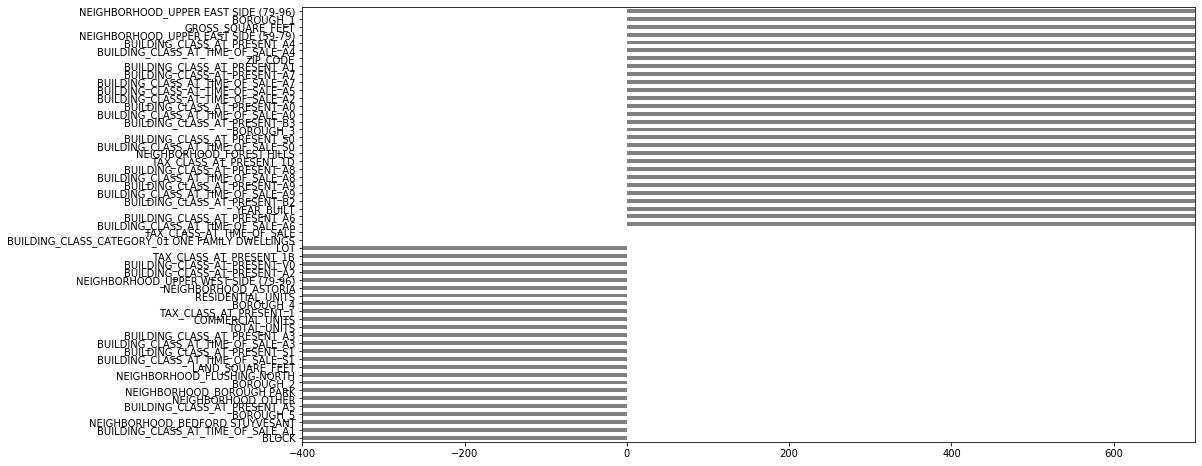

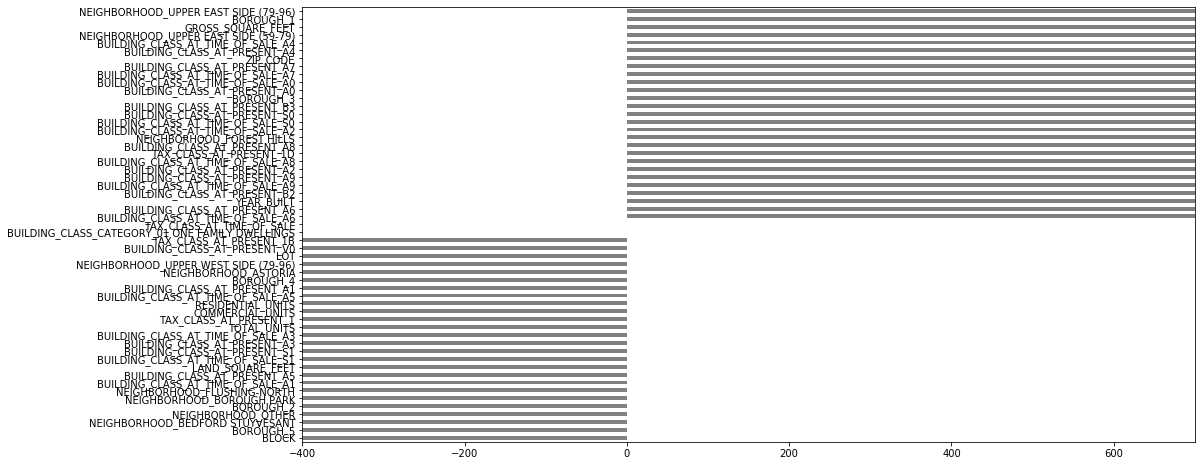

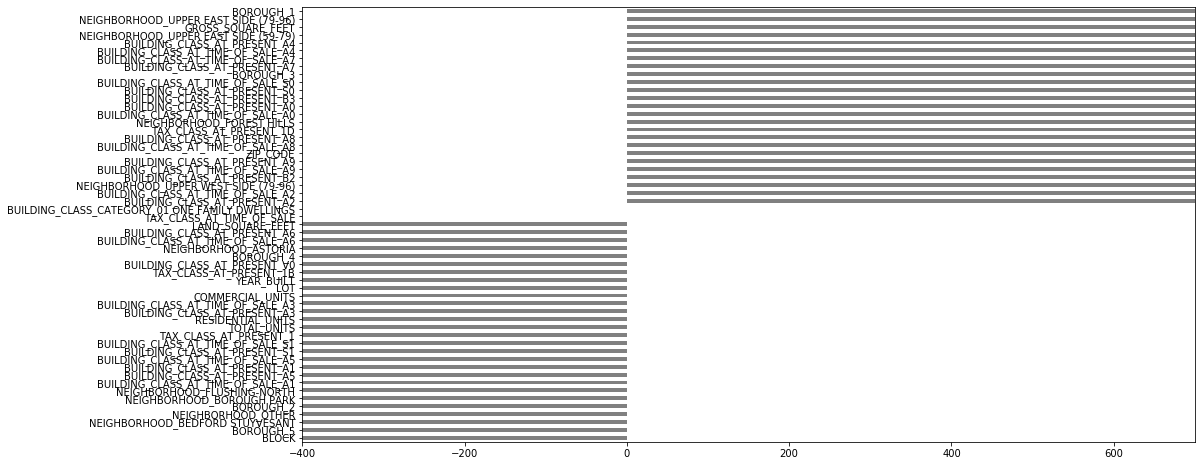

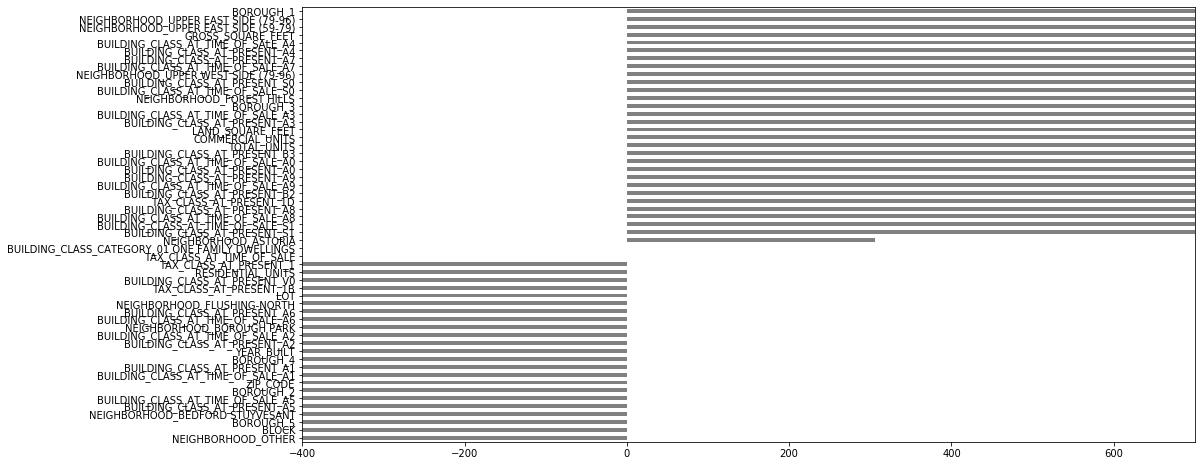

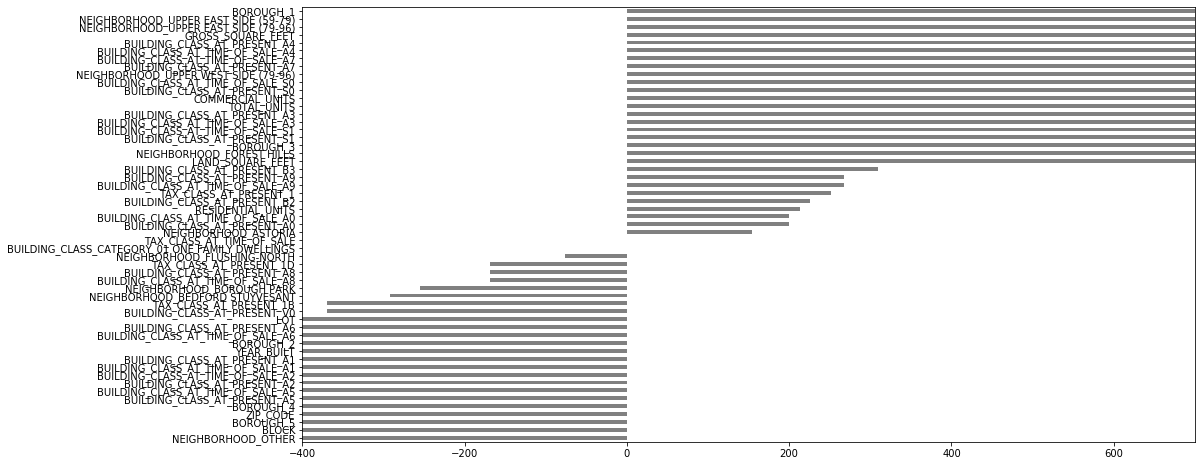

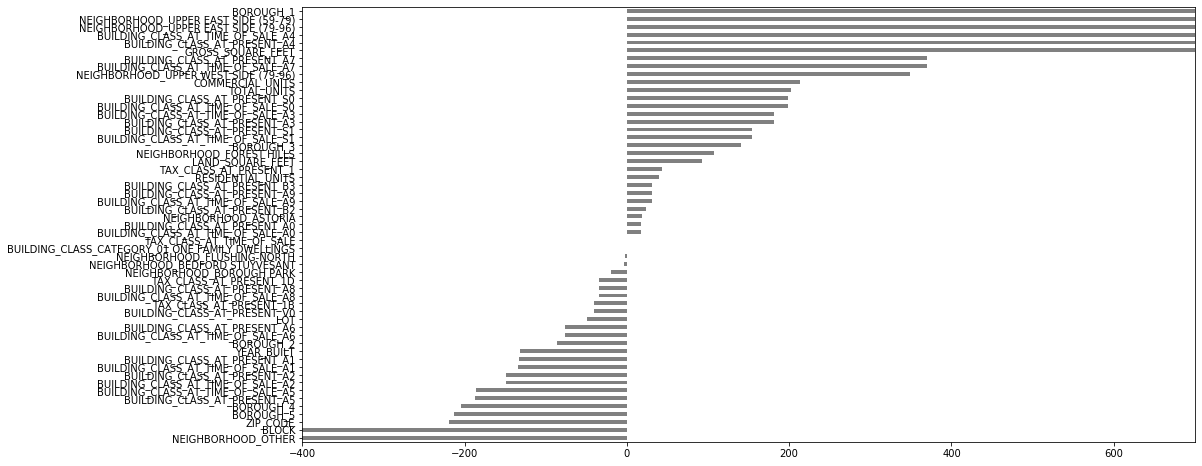

In [39]:
%matplotlib inline
from IPython.display import display, HTML
from ipywidgets import interact
import matplotlib.pyplot as plt
from sklearn.linear_model import Ridge
from sklearn.preprocessing import StandardScaler


for alpha in [10**1, 10**2, 10**3, 10**4, 10**5, 10**6]:
    
    # Question about this
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    
    # Ridge Regression
    display(HTML(f'Ridge Regression, with alpha={alpha}'))
    model = Ridge(alpha=alpha)
    model.fit(X_train_scaled, y_train)
    y_pred = model.predict(X_test_scaled)

    # MAE
    mae = mean_absolute_error(y_test, y_pred)
    display(HTML(f'Test Mean Absolute Error: ${mae:,.0f}'))
    
    # Plot coefficients
    coefficients = pd.Series(model.coef_, X_train.columns)
    plt.figure(figsize=(16,8))
    coefficients.sort_values().plot.barh(color='grey')
    plt.xlim(-400,700)
    plt.show()